In [1]:
from pruners.pruning_methods import L1Unstructured, RandUnstructured
import torch
from evaluations.evaluator import Evaluator
from tqdm import tqdm
from transformers import AutoTokenizer, BertForSequenceClassification
from explainers.explanation_methods import SHAP, LIME
import torch
from copy import deepcopy

device = torch.device('cpu')

In [2]:
# returns a list of model params given a bert `model`
def get_params_to_prune(model):
    params_to_prune = []
    for layer in model.bert.encoder.layer:
        # Attention weights (query, key, value, and output projection)
        params_to_prune.append((layer.attention.self.query, 'weight'))
        params_to_prune.append((layer.attention.self.key, 'weight'))
        params_to_prune.append((layer.attention.self.value, 'weight'))
        params_to_prune.append((layer.attention.output.dense, 'weight'))
        
        # Intermediate dense layer
        params_to_prune.append((layer.intermediate.dense, 'weight'))
        
        # Output dense layer
        params_to_prune.append((layer.output.dense, 'weight'))
        
    return params_to_prune


def eval_suite(model, tokenizer, inputs, prune_ptg):
    # TODO: Refactor
    
    model.to(device)
    # Init models and grab model params to prune
    randunstructured_model = deepcopy(model).to(device)
    l1unstructured_model = deepcopy(model).to(device)

    randunstruct_params = get_params_to_prune(randunstructured_model)
    l1unstruct_params = get_params_to_prune(l1unstructured_model)

    # Initialize pruners and make pruned models
    print('Pruning models...')
    unpruned_model = model
    
    randunstructured_pruner = RandUnstructured()
    l1unstructured_pruner = L1Unstructured()
    randunstructured_pruner.prune(randunstruct_params, prune_ptg)
    l1unstructured_pruner.prune(l1unstruct_params, prune_ptg)

    # Init explainers
    shap_randunstruct, lime_randunstruct = SHAP(randunstructured_model, tokenizer, device),\
                                           LIME(randunstructured_model, tokenizer, device)
    shap_l1unstruct, lime_l1unstruct = SHAP(l1unstructured_model, tokenizer, device),\
                                       LIME(l1unstructured_model, tokenizer, device)
    shap_unpruned, lime_unpruned = SHAP(unpruned_model, tokenizer, device),\
                                   LIME(unpruned_model, tokenizer, device)
    
    # Init evaluators
    randunstruct_evaluators = {'shap': Evaluator(shap_randunstruct)}
                               #'lime': Evaluator(lime_randunstruct)}
    l1unstruct_evaluators = {'shap': Evaluator(shap_l1unstruct)}
                            # 'lime': Evaluator(lime_l1unstruct)}
    unrpuned_evaluators = {'shap': Evaluator(shap_unpruned)}
                           #'lime': Evaluator(lime_unpruned)}

    # Janky for now but hang with me
    infidelities_ = {'unpruned': unrpuned_evaluators,
                    'l1unstruct': l1unstruct_evaluators,
                    'randunstruct': randunstruct_evaluators}
    
    # Run evaluations, storing in dictionary of 
    # {prune_method: 
    #   {explanation_method: infidelity}
    # }
    print('Evaluating explanations...')
    infidelities = {}
    for input in tqdm(inputs, desc='Evaluating', unit='input'):
        for prune_method, evaluator_set in infidelities_.items():
            # Initialize prune_method in infidelities if not present
            if prune_method not in infidelities:
                infidelities[prune_method] = {}  # Initialize prune_method dict
            
            for expla_method, evaluator in evaluator_set.items():
                # Initialize expla_method as a list if not present
                if expla_method not in infidelities[prune_method]:
                    infidelities[prune_method][expla_method] = []
                
                # Append the result of get_local_infidelity to the list
                infidelities[prune_method][expla_method].append(evaluator.get_local_infidelity(input))

    return infidelities

In [3]:
device = torch.device('mps')
tokenizer = AutoTokenizer.from_pretrained(
    "textattack/bert-base-uncased-yelp-polarity")
model = BertForSequenceClassification.from_pretrained(
    "textattack/bert-base-uncased-yelp-polarity")
model = model.to(device)

inputs = ['Camilo CANNOT CODE FOR HIS LIFE. I DONT LIKE HIM!!!!',
          'David is GREAT at soccer. Can recommend <thumbs up>!',
          'Joey is joey. I feel very neutrally about him',
          'Finale is the best professor Harvard has EVER had. Would recommend!',
          'I AM GOING TO SCREAMMMMMMMMMMM AHHHHHHHHHHHH',
          'Paula and Hiwot are great TFs!']

infidelities = eval_suite(model, tokenizer, inputs, .20)

Pruning models...


/Users/jbejjani/Programming/harvardCS/PruningExplainability/env/lib/python3.12/site-packages/torch/nn/utils/prune.py:398: UserWarning: MPS: nonzero op is not natively supported for the provided input on MacOS14Falling back on CPU. This may have performance implications.See github.com/pytorch/pytorch/issues/122916 for further info (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Indexing.mm:309.)
  partial_mask = method.compute_mask(t[slc], default_mask=mask[slc])


Evaluating explanations...


Evaluating: 100%|██████████| 6/6 [00:59<00:00,  9.85s/input]


In [4]:
infidelities

{'unpruned': {'shap': [16.69713020324707,
   0.06618621945381165,
   0.47683054208755493,
   0.15279465913772583,
   25.010791778564453,
   0.16142608225345612]},
 'l1unstruct': {'shap': [9.17068862915039,
   0.0021877989638596773,
   0.5857784748077393,
   0.0052423435263335705,
   0.004955428186804056,
   0.06795432418584824]},
 'randunstruct': {'shap': [3.7190706729888916,
   0.6367701888084412,
   0.19003073871135712,
   0.009637688286602497,
   0.43171846866607666,
   0.21862871944904327]}}

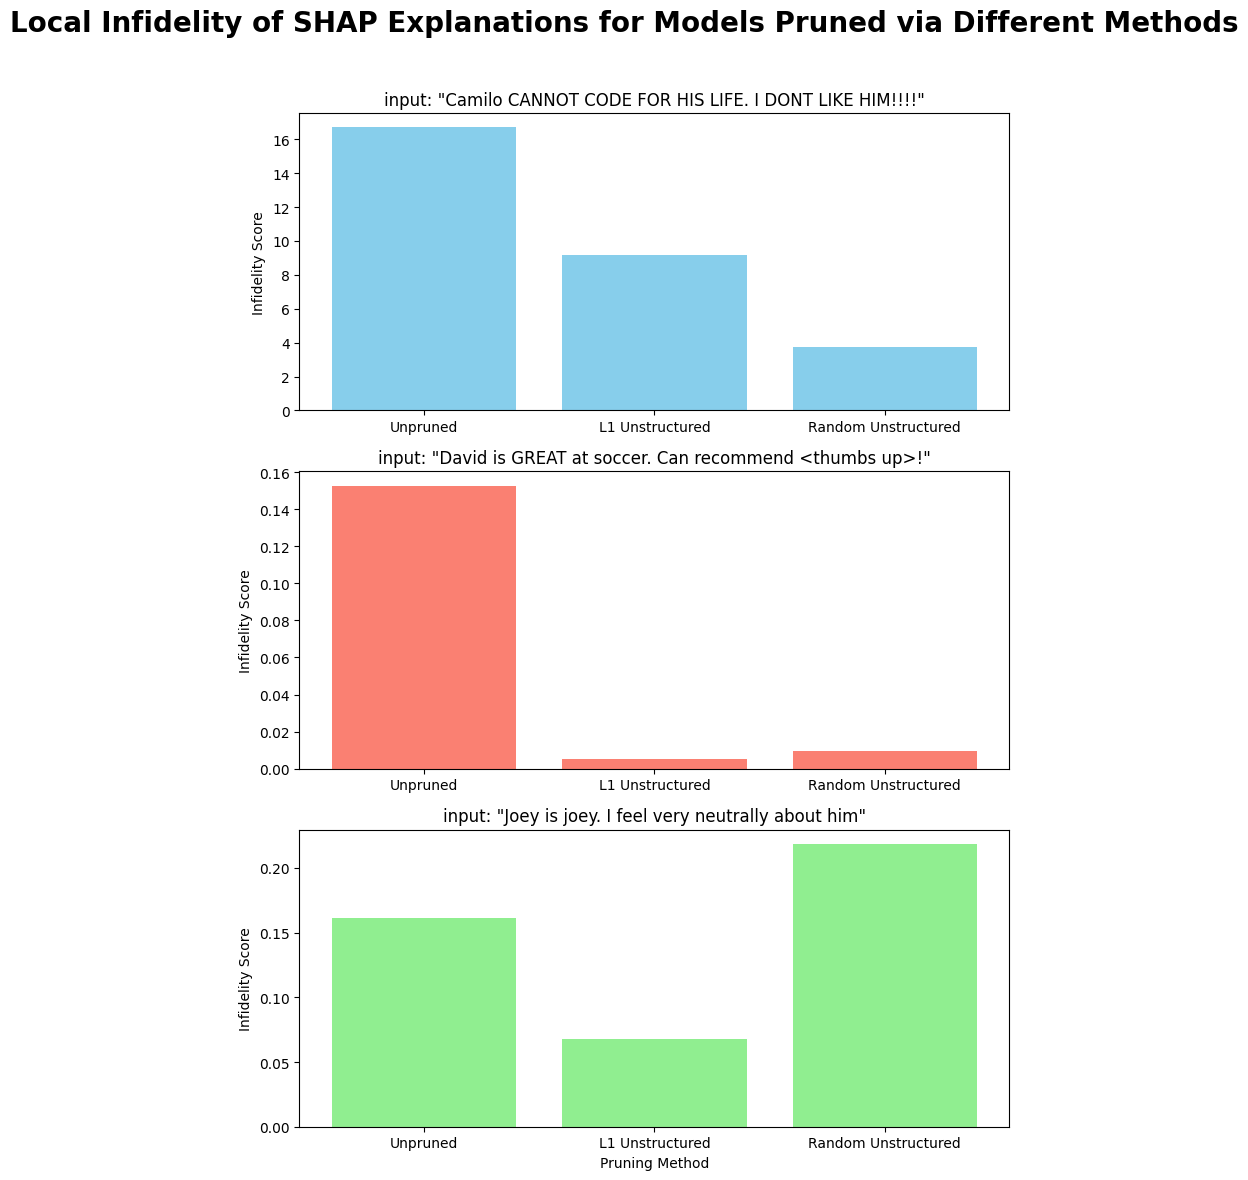

In [11]:
import matplotlib.pyplot as plt


categories = ['unpruned', 'l1unstruct', 'randunstruct']
vals1 = [infidelities[c]['shap'][0] for c in categories]
vals2 = [infidelities[c]['shap'][3] for c in categories]
vals3 = [infidelities[c]['shap'][5] for c in categories]
    
# Create a 3x1 subplot layout
fig, axs = plt.subplots(3, 1, figsize=(8, 12))
xlabels = ['Unpruned', 'L1 Unstructured', 'Random Unstructured']

# Setting an overarching title for the entire figure
fig.suptitle('Local Infidelity of SHAP Explanations for Models Pruned via Different Methods', fontsize=20, fontweight='bold')

# Plot each subplot with individual data and titles
axs[0].bar(xlabels, vals1, color='skyblue')
axs[1].bar(xlabels, vals2, color='salmon')
axs[2].bar(xlabels, vals3, color='lightgreen')

for i in range(len(categories)):
    axs[i].set_title(f'input: "{inputs[i]}"')
    axs[i].set_ylabel('Infidelity Score')


axs[2].set_xlabel('Pruning Method')

# Customizing the layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout for the overarching title


plt.show()
